In [45]:
import os
os.chdir(r'D:\Engr Course\VSCode\ML')

In [46]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from timeseires.utils.to_split import to_split
from timeseires.utils.multivariate_multi_step import multivariate_multi_step
from timeseires.utils.multivariate_single_step import multivariate_single_step
from timeseires.utils.univariate_multi_step import univariate_multi_step
from timeseires.utils.univariate_single_step import univariate_single_step
from timeseires.utils.CosineAnnealingLRS import CosineAnnealingLRS
from timeseires.callbacks.EpochCheckpoint import EpochCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import LSTM, Bidirectional, Add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv1D,TimeDistributed
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,MaxPooling1D,Concatenate,AveragePooling1D, GlobalMaxPooling1D, Input, SimpleRNN
from tensorflow.keras.models import Sequential,Model
import pandas as pd
import time, pickle
import numpy as np
import tensorflow.keras.backend as K
import tensorflow
from tensorflow.keras.layers import Input, Reshape, Lambda
from tensorflow.keras.layers import Layer, Flatten, LeakyReLU, concatenate, Dense
from tensorflow.keras.regularizers import l2
import glob
import h5py
import matplotlib.pyplot as plt
from keras.callbacks import Callback

In [47]:
#lookback = 24
model = None
start_epoch = 0
time_steps=24
num_features=21

In [48]:
def create_rnn():
    input_data = Input(shape=(time_steps, num_features))
    rnn_layer1 = SimpleRNN(8, return_sequences=True)(input_data)
    rnn_layer2 = SimpleRNN(20)(rnn_layer1)
    x = Flatten()(rnn_layer2)
    output_data = Dense(1)(x)
    model = Model(input_data, output_data)
    return model

In [49]:
model = create_rnn()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 24, 21)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_8 (SimpleRNN)        │ (None, 24, 8)          │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_9 (SimpleRNN)        │ (None, 20)             │           580 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 20)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            21 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 841 (3.29 KB)

 Trainable params: 841 (3.29 KB)

 Non-trainable params: 0 (0.00 B)

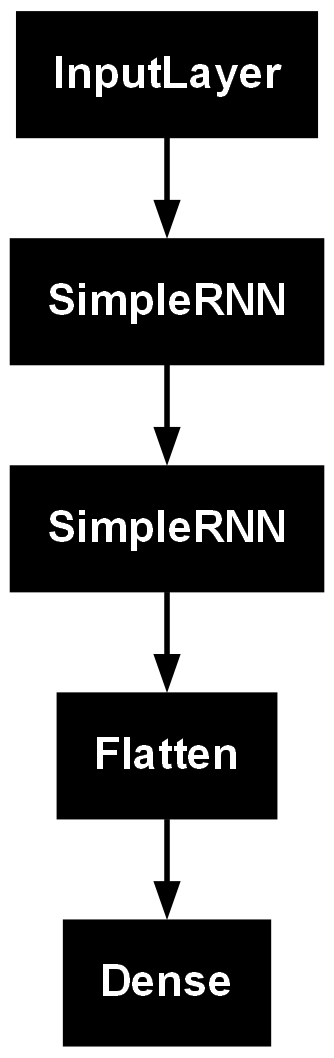

In [50]:
tensorflow.keras.utils.plot_model(model)

In [51]:
checkpoints = r'C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
OUTPUT_PATH = r'C:\Users\swiss\Desktop\ML\Lab 9\checkpoint\ML Lab\lab9'
#FIG_PATH = os.path.sep.join([OUTPUT_PATH,"\history.png"])
#JSON_PATH = os.path.sep.join([OUTPUT_PATH,"\history.json"])

In [52]:
EpochCheckpoint = ModelCheckpoint(checkpoints,
                             monitor="val_loss",
                             save_best_only=True, 
                             verbose=1)
#TrainingMonitor1=TrainingMonitor(FIG_PATH, jsonPath=JSON_PATH, startAt=start_epoch)

# construct the set of callbacks
callbacks = [EpochCheckpoint]

In [58]:
print("[INFO] compiling model...")
model =create_rnn()
opt = Adam(1e-3)
model.compile(loss= 'mae', optimizer=opt, metrics=["mae", "mape"])

[INFO] compiling model...


In [59]:
import os
path_dataset =r'C:\Users\swiss\Desktop\ML\Lab 7'
path_tr = os.path.join(path_dataset, 'AEP_train.csv')
df_tr = pd.read_csv(path_tr)
train_set = df_tr.iloc[:].values
path_v = os.path.join(path_dataset, 'AEP_validation.csv')
df_v = pd.read_csv(path_v)
validation_set = df_v.iloc[:].values 
path_te = os.path.join(path_dataset, 'AEP_test.csv')
df_te = pd.read_csv(path_te)
test_set = df_te.iloc[:].values 

path_scaler = os.path.join(path_dataset, 'AEP_Scaler.pkl')
scaler         = pickle.load(open(path_scaler, 'rb'))

train_set.shape, validation_set.shape, test_set.shape

d:\Engr Course\VSCode\ML\Lib\site-packages\sklearn\base.py:380: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.0.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


((84907, 21), (24259, 21), (12130, 21))

In [60]:
time_steps=24
num_features=21

In [61]:
start = time.time()
train_X , train_y = univariate_multi_step(train_set, time_steps, target_col=0,target_len=1)
validation_X, validation_y = univariate_multi_step(validation_set, time_steps, target_col=0,target_len=1)
test_X, test_y = univariate_multi_step(test_set, time_steps, target_col=0,target_len=1)
print('Time Consumed', time.time()-start, "sec")

Time Consumed 0.8496363162994385 sec


In [63]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks = callbacks, verbose = verbose)

Epoch 1/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0140 - mae: 0.0140 - mape: 240.5564
Epoch 1: val_loss improved from 0.01480 to 0.01355, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0001-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 47s 18ms/step - loss: 0.0140 - mae: 0.0140 - mape: 240.5412 - val_loss: 0.0136 - val_mae: 0.0136 - val_mape: 7.2530
Epoch 2/10
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0132 - mae: 0.0132 - mape: 18.7503
Epoch 2: val_loss did not improve from 0.01355
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 43s 16ms/step - loss: 0.0132 - mae: 0.0132 - mape: 19.0685 - val_loss: 0.0138 - val_mae: 0.0138 - val_mape: 5.9631
Epoch 3/10
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0127 - mae: 0.0127 - mape: 48.1553
Epoch 3: val_loss improved from 0.01355 to 0.01127, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0003-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0127 - mae: 0.0127 - mape: 48.3383 - val_loss: 0.0113 - val_mae: 0.0113 - val_mape: 4.9494
Epoch 4/10
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0122 - mae: 0.0122 - mape: 92.5776
Epoch 4: val_loss did not improve from 0.01127
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 50s 19ms/step - loss: 0.0122 - mae: 0.0122 - mape: 92.6474 - val_loss: 0.0114 - val_mae: 0.0114 - val_mape: 5.8467
Epoch 5/10
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0116 - mae: 0.0116 - mape: 29.1342
Epoch 5: val_loss improved from 0.01127 to 0.01025, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0005-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0116 - mae: 0.0116 - mape: 29.1182 - val_loss: 0.0103 - val_mae: 0.0103 - val_mape: 5.1409
Epoch 6/10
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0111 - mae: 0.0111 - mape: 379.4239
Epoch 6: val_loss improved from 0.01025 to 0.00981, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0006-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0111 - mae: 0.0111 - mape: 379.3795 - val_loss: 0.0098 - val_mae: 0.0098 - val_mape: 4.6285
Epoch 7/10
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0107 - mae: 0.0107 - mape: 61.1159
Epoch 7: val_loss did not improve from 0.00981
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0107 - mae: 0.0107 - mape: 61.2730 - val_loss: 0.0102 - val_mae: 0.0102 - val_mape: 5.0893
Epoch 8/10
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0103 - mae: 0.0103 - mape: 730.6844
Epoch 8: val_loss improved from 0.00981 to 0.00941, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0008-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 39s 15ms/step - loss: 0.0103 - mae: 0.0103 - mape: 730.4013 - val_loss: 0.0094 - val_mae: 0.0094 - val_mape: 5.0358
Epoch 9/10
2650/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0101 - mae: 0.0101 - mape: 65.2526
Epoch 9: val_loss did not improve from 0.00941
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0101 - mae: 0.0101 - mape: 65.2546 - val_loss: 0.0100 - val_mae: 0.0100 - val_mape: 4.4611
Epoch 10/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0098 - mae: 0.0098 - mape: 29.7744
Epoch 10: val_loss did not improve from 0.00941
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 41s 15ms/step - loss: 0.0098 - mae: 0.0098 - mape: 29.8360 - val_loss: 0.0128 - val_mae: 0.0128 - val_mape: 5.7478


In [ ]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# Load the model (avoid compile errors by setting compile=False if needed)
model = load_model(r'C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0008-loss0.01.h5', compile=False)

# Predict
y_pred_scaled = model.predict(test_X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)

# Metrics Calculation
MAE = mean_absolute_error(y_test_unscaled, y_pred)
MEDAE = median_absolute_error(y_test_unscaled, y_pred)
MSE = mean_squared_error(y_test_unscaled, y_pred)
RMSE = np.sqrt(MSE)

# Safe MAPE and MDAPE (handle division by zero)
epsilon = 1e-10
denominator = np.where(np.abs(y_test_unscaled) < epsilon, epsilon, y_test_unscaled)
MAPE = np.mean(np.abs((y_test_unscaled - y_pred) / denominator)) * 100
MDAPE = np.median(np.abs((y_test_unscaled - y_pred) / denominator)) * 100

# Print Results
print(f"Mean Absolute Error (MAE):        {MAE:.2f}")
print(f"Median Absolute Error (MedAE):    {MEDAE:.2f}")
print(f"Mean Squared Error (MSE):         {MSE:.2f}")
print(f"Root Mean Squared Error (RMSE):   {RMSE:.2f}")
print(f"Mean Absolute Percentage Error (MAPE):   {MAPE:.2f} %")
print(f"Median Absolute Percentage Error (MDAPE): {MDAPE:.2f} %")

# Shape Check
print("\nShapes:")
print(f"y_test_unscaled: {y_test_unscaled.shape}")
print(f"y_pred:          {y_pred.shape}")

379/379 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step
Mean Absolute Error (MAE):        144.53
Median Absolute Error (MedAE):    116.64
Mean Squared Error (MSE):         35332.28
Root Mean Squared Error (RMSE):   187.97
Mean Absolute Percentage Error (MAPE):   1.00 %
Median Absolute Percentage Error (MDAPE): 0.80 %

Shapes:
y_test_unscaled: (12105, 1)
y_pred:          (12105, 1)


In [ ]:
checkpoints = r'C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'
model1=r'C:\Users\swiss\Desktop\ML\Lab 9\E1-cp-0008-loss0.01.h5'
start_epoch= 9

In [77]:
class PowerConsumptionModel:
    @staticmethod
    def build(time_steps, num_features, reg):
        # define your Keras model here
        return model

In [80]:
from keras.models import load_model
from keras.optimizers import Adam
from keras.losses import MeanAbsoluteError
from keras.metrics import MeanAbsolutePercentageError
from keras.callbacks import ModelCheckpoint
import keras.backend as K
import os


# Path to model checkpoint
checkpoints = r'C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-{epoch:04d}-loss{val_loss:.2f}.h5'

# Define callbacks
EpochCheckpoint1 = ModelCheckpoint(
    checkpoints,
    monitor="val_loss",
    save_best_only=True,
    verbose=1
)
callbacks = [EpochCheckpoint1]

# If checkpoint doesn't exist, compile a new model
if not os.path.exists(checkpoints):
    print("[INFO] compiling model...")
    model = PowerConsumptionModel.build(time_steps=24, num_features=21, reg=0.0005)
    opt = Adam(1e-3)
    model.compile(loss='mae', optimizer=opt, metrics=["mae", "mape"])
else:
    # Load the model
    print(f"[INFO] loading model from {checkpoints}...")
    custom_objects = {
        'mae': MeanAbsoluteError(),
        'mape': MeanAbsolutePercentageError()
    }
    model = load_model(checkpoints, custom_objects=custom_objects)

    # Update learning rate
    old_lr = K.get_value(model.optimizer.lr)
    print(f"[INFO] old learning rate: {old_lr}")
    K.set_value(model.optimizer.lr, 1e-4)
    print(f"[INFO] new learning rate: {K.get_value(model.optimizer.lr)}")


[INFO] compiling model...


In [81]:
epochs = 10
verbose = 1 #0
batch_size = 32
History = model.fit(train_X,
                        train_y,
                        batch_size=batch_size,   
                        epochs = epochs, 
                        validation_data = (validation_X,validation_y),
                        callbacks=callbacks,
                        verbose = verbose)

Epoch 1/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0094 - mae: 0.0094 - mape: 247.3583
Epoch 1: val_loss improved from inf to 0.00884, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-0001-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 49s 16ms/step - loss: 0.0094 - mae: 0.0094 - mape: 247.3484 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 4.6011
Epoch 2/10
2651/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0091 - mae: 0.0091 - mape: 18.6007
Epoch 2: val_loss did not improve from 0.00884
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 53s 20ms/step - loss: 0.0091 - mae: 0.0091 - mape: 18.9146 - val_loss: 0.0112 - val_mae: 0.0112 - val_mape: 6.0932
Epoch 3/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0089 - mae: 0.0089 - mape: 181.7989
Epoch 3: val_loss did not improve from 0.00884
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0089 - mae: 0.0089 - mape: 181.7949 - val_loss: 0.0093 - val_mae: 0.0093 - val_mape: 4.8249
Epoch 4/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0087 - mae: 0.0087 - mape: 41.7324
Epoch 4: val_loss did not improve from 0.00884
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 44s 16ms/step - loss: 0.0087 - mae: 0.0087 - mape: 41.7848 - val_loss: 0.0100 - val_mae

2653/2653 ━━━━━━━━━━━━━━━━━━━━ 42s 16ms/step - loss: 0.0087 - mae: 0.0087 - mape: 42.6905 - val_loss: 0.0088 - val_mae: 0.0088 - val_mape: 3.9798
Epoch 6/10
2648/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0086 - mae: 0.0086 - mape: 295.6519
Epoch 6: val_loss did not improve from 0.00876
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0086 - mae: 0.0086 - mape: 295.4460 - val_loss: 0.0091 - val_mae: 0.0091 - val_mape: 4.6845
Epoch 7/10
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - mae: 0.0085 - mape: 478.6481
Epoch 7: val_loss improved from 0.00876 to 0.00820, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-0007-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0085 - mae: 0.0085 - mape: 478.1693 - val_loss: 0.0082 - val_mae: 0.0082 - val_mape: 3.7267
Epoch 8/10
2649/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0085 - mae: 0.0085 - mape: 25.5437
Epoch 8: val_loss improved from 0.00820 to 0.00793, saving model to C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-0008-loss0.01.h5


2653/2653 ━━━━━━━━━━━━━━━━━━━━ 40s 14ms/step - loss: 0.0085 - mae: 0.0085 - mape: 25.7859 - val_loss: 0.0079 - val_mae: 0.0079 - val_mape: 3.4656
Epoch 9/10
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0084 - mae: 0.0084 - mape: 100.6684
Epoch 9: val_loss did not improve from 0.00793
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 38s 14ms/step - loss: 0.0084 - mae: 0.0084 - mape: 100.7136 - val_loss: 0.0139 - val_mae: 0.0139 - val_mape: 6.9336
Epoch 10/10
2652/2653 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0083 - mae: 0.0083 - mape: 47.3594
Epoch 10: val_loss did not improve from 0.00793
2653/2653 ━━━━━━━━━━━━━━━━━━━━ 32s 12ms/step - loss: 0.0083 - mae: 0.0083 - mape: 47.4528 - val_loss: 0.0083 - val_mae: 0.0083 - val_mape: 3.8813


In [83]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

# Load the model (avoid compile errors by setting compile=False if needed)
model = load_model(r'C:\Users\swiss\Desktop\ML\Lab 9\E2-cp-0008-loss0.01.h5', compile=False)

# Predict
y_pred_scaled = model.predict(test_X)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler.inverse_transform(test_y)

# Metrics Calculation
MAE = mean_absolute_error(y_test_unscaled, y_pred)
MEDAE = median_absolute_error(y_test_unscaled, y_pred)
MSE = mean_squared_error(y_test_unscaled, y_pred)
RMSE = np.sqrt(MSE)

# Safe MAPE and MDAPE (handle division by zero)
epsilon = 1e-10
denominator = np.where(np.abs(y_test_unscaled) < epsilon, epsilon, y_test_unscaled)
MAPE = np.mean(np.abs((y_test_unscaled - y_pred) / denominator)) * 100
MDAPE = np.median(np.abs((y_test_unscaled - y_pred) / denominator)) * 100

# Print Results
print(f"Mean Absolute Error (MAE):        {MAE:.2f}")
print(f"Median Absolute Error (MedAE):    {MEDAE:.2f}")
print(f"Mean Squared Error (MSE):         {MSE:.2f}")
print(f"Root Mean Squared Error (RMSE):   {RMSE:.2f}")
print(f"Mean Absolute Percentage Error (MAPE):   {MAPE:.2f} %")
print(f"Median Absolute Percentage Error (MDAPE): {MDAPE:.2f} %")

# Shape Check
print("\nShapes:")
print(f"y_test_unscaled: {y_test_unscaled.shape}")
print(f"y_pred:          {y_pred.shape}")

379/379 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Mean Absolute Error (MAE):        126.62
Median Absolute Error (MedAE):    102.83
Mean Squared Error (MSE):         26885.55
Root Mean Squared Error (RMSE):   163.97
Mean Absolute Percentage Error (MAPE):   0.87 %
Median Absolute Percentage Error (MDAPE): 0.71 %

Shapes:
y_test_unscaled: (12105, 1)
y_pred:          (12105, 1)
